In [65]:
### imports
import requests
from bs4 import BeautifulSoup
import pandas as pd
import re
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
# Define the base URL
base_url = 'https://www.zameen.com'

# Create a session object for making HTTP requests
session = requests.Session()

# Send a GET request to the areas page
response = session.get(f'{base_url}/all_locations/Karachi-2-1-1.html')

In [24]:
### EXTRACTING THE LINKS OF PROPERTY PAGE BY AREAS

# Parsing the HTML content
html_parser = BeautifulSoup(response.content, 'html.parser')

# Finding all divs having the areas info
areas_div = html_parser.find('div', id='sub-location-list')

# Extracting the areas hyperlinks
areas_hyperlinks = areas_div.find_all('a')

print(areas_hyperlinks)

[<a href="https://www.zameen.com/Homes/Karachi_Bahria_Town_Karachi-8298-1.html">Bahria Town Karachi</a>, <a href="https://www.zameen.com/Homes/Karachi_DHA_Defence-213-1.html">DHA Defence</a>, <a href="https://www.zameen.com/Homes/Karachi_Gulshan_e_Iqbal_Town-6858-1.html">Gulshan-e-Iqbal Town</a>, <a href="https://www.zameen.com/Homes/Karachi_Gulistan_e_Jauhar-232-1.html">Gulistan-e-Jauhar</a>, <a href="https://www.zameen.com/Homes/Karachi_North_Nazimabad-11-1.html">North Nazimabad</a>, <a href="https://www.zameen.com/Homes/Karachi_Scheme_33-495-1.html">Scheme 33</a>, <a href="https://www.zameen.com/Homes/Karachi_Gadap_Town-570-1.html">Gadap Town</a>, <a href="https://www.zameen.com/Homes/Karachi_North_Karachi-282-1.html">North Karachi</a>, <a href="https://www.zameen.com/Homes/Karachi_Federal_B._Area-12-1.html">Federal B Area</a>, <a href="https://www.zameen.com/Homes/Karachi_Malir-476-1.html">Malir</a>, <a href="https://www.zameen.com/Homes/Karachi_Nazimabad-278-1.html">Nazimabad</a>,

In [28]:
### THIS CELL IS SCRAPPING DATA OF PROPERTIES AREA WISE AND PUSHING THEM IN A DICTIONARY
### WE ALREADY HAVE A CSV FOR THIS SCRAPPED DATA SO DONT NEED TO RUN IT EVERY TIME
### AS THE CELL EXECUTION MIGHT TAKE UPTO 30 MINS

result = {}

# Process each city link
for link in areas_hyperlinks:
    area_url = link['href']
    area_name = link.text.strip()    # Getting Area Name
    
    # Send a GET request to the area's property listings page
    response = session.get(area_url)
    
    # Parsing the HTML content for Each Area Hyperlink
    html_parser = BeautifulSoup(response.content, 'html.parser')
    
    # Find all property links on the page
    property_links = html_parser.find_all('a', class_='_7ac32433')
    
    # Create a list to store the property details for the city
    properties_list = []
    
    # Process each property link
    for property_link in property_links:
        property_url = f"{base_url}{property_link['href']}"
        
        # Send a GET request to the property page
        property_response = session.get(property_url)
        
        # Parse the HTML content of the property page
        property_soup = BeautifulSoup(property_response.content, 'html.parser')
        
        # Extract and process property details
        details_container = property_soup.find('ul', class_='_033281ab')
        
        if details_container:
            details_items = details_container.find_all('li')
            
            property_details = {}
            
            for item in details_items:
                key = item.find('span', class_='_3af7fa95').text.strip()
                value = item.find('span', class_='_812aa185').text.strip()
                property_details[key] = value
            
            # Append the property details to the city's properties list
            properties_list.append(property_details)
    
    # Add the city's properties list to the result dictionary
    result[area_name] = properties_list

In [39]:
### Normalizing the RESULT object so it can be saved in a csv

# Create an empty DataFrame to store the normalized data
df = pd.DataFrame()

# Iterate over each area and its properties
for area, properties in result.items():
    # Convert properties to DataFrame
    area_df = pd.DataFrame(properties)
    
    # Add a 'City' column with the city name
    area_df['Area Name'] = area
    
    # Append the city_df to the main DataFrame
    df = df.append(area_df, ignore_index=True)

# Save the DataFrame to a CSV file
csv_file = 'property_data2.csv'
df.to_csv(csv_file, index=False)
print(f"Data saved to {csv_file}")

Data saved to property_data2.csv


In [40]:
df = pd.read_csv("property_data2.csv")

In [41]:
### Normalization/Standardization

### Removing "PKR" from all values in the column "PRICE"
df['Price'] = df['Price'].str.replace('PKR', '')

# Step 2: Convert the values to digits
def convert_to_digits(value):
    numeric_value = re.search(r'([\d.]+)', value)
    if numeric_value:
        numeric_value = float(numeric_value.group(1))
    else:
        return value

    if 'Hundred' in value:
        return numeric_value * 100
    elif 'Thousand' in value:
        return numeric_value * 1000
    elif 'Lakh' in value:
        return numeric_value * 100000
    elif 'Crore' in value:
        return numeric_value * 10000000
    else:
        return numeric_value

df['Price'] = df['Price'].apply(convert_to_digits)

In [46]:
### Convert columns to numeric
numeric_columns = ['Price', 'Bath(s)', 'Bedroom(s)', 'Initial Amount', 'Monthly Installment', 'Remaining Installments']
df[numeric_columns] = df[numeric_columns].apply(pd.to_numeric, errors='coerce')

### Filling NaN with 0 to standardize the data 
df['Initial Amount'] = df['Initial Amount'].fillna(0)
df['Monthly Installment'] = df['Monthly Installment'].fillna(0)
df['Remaining Installments'] = df['Remaining Installments'].fillna(0)

display(df.head())

,Type,Price,Location,Bath(s),Area,Purpose,Bedroom(s),Added,Initial Amount,Monthly Installment,Remaining Installments,Area Name
0,House,14300000.0,"Bahria Town Karachi, Karachi, Sindh",4.0,152 Sq. Yd.,For Sale,3.0,36 minutes ago,0.0,0.0,0.0,Bahria Town Karachi
1,House,32500000.0,"Bahria Town Karachi, Karachi, Sindh",5.0,500 Sq. Yd.,For Sale,5.0,1 hour ago,0.0,0.0,0.0,Bahria Town Karachi
2,House,18500000.0,"Bahria Town Karachi, Karachi, Sindh",3.0,200 Sq. Yd.,For Sale,3.0,1 hour ago,0.0,0.0,0.0,Bahria Town Karachi
3,Flat,6000000.0,"Bahria Town Karachi, Karachi, Sindh",2.0,122 Sq. Yd.,For Sale,2.0,2 hours ago,0.0,0.0,0.0,Bahria Town Karachi
4,House,17000000.0,"Bahria Town Karachi, Karachi, Sindh",3.0,200 Sq. Yd.,For Sale,3.0,2 hours ago,0.0,0.0,0.0,Bahria Town Karachi


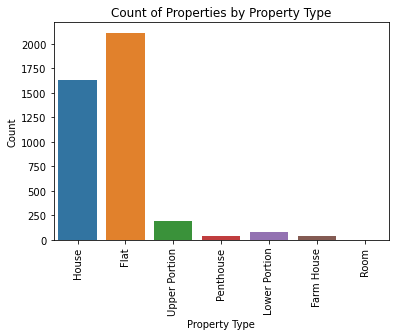

In [50]:
### Bar Plot - Count of Properties w.r.t Property Type

sns.countplot(x='Type', data=df)
plt.xlabel('Property Type')
plt.ylabel('Count')
plt.title('Count of Properties by Property Type')
plt.xticks(rotation=90)
plt.show()

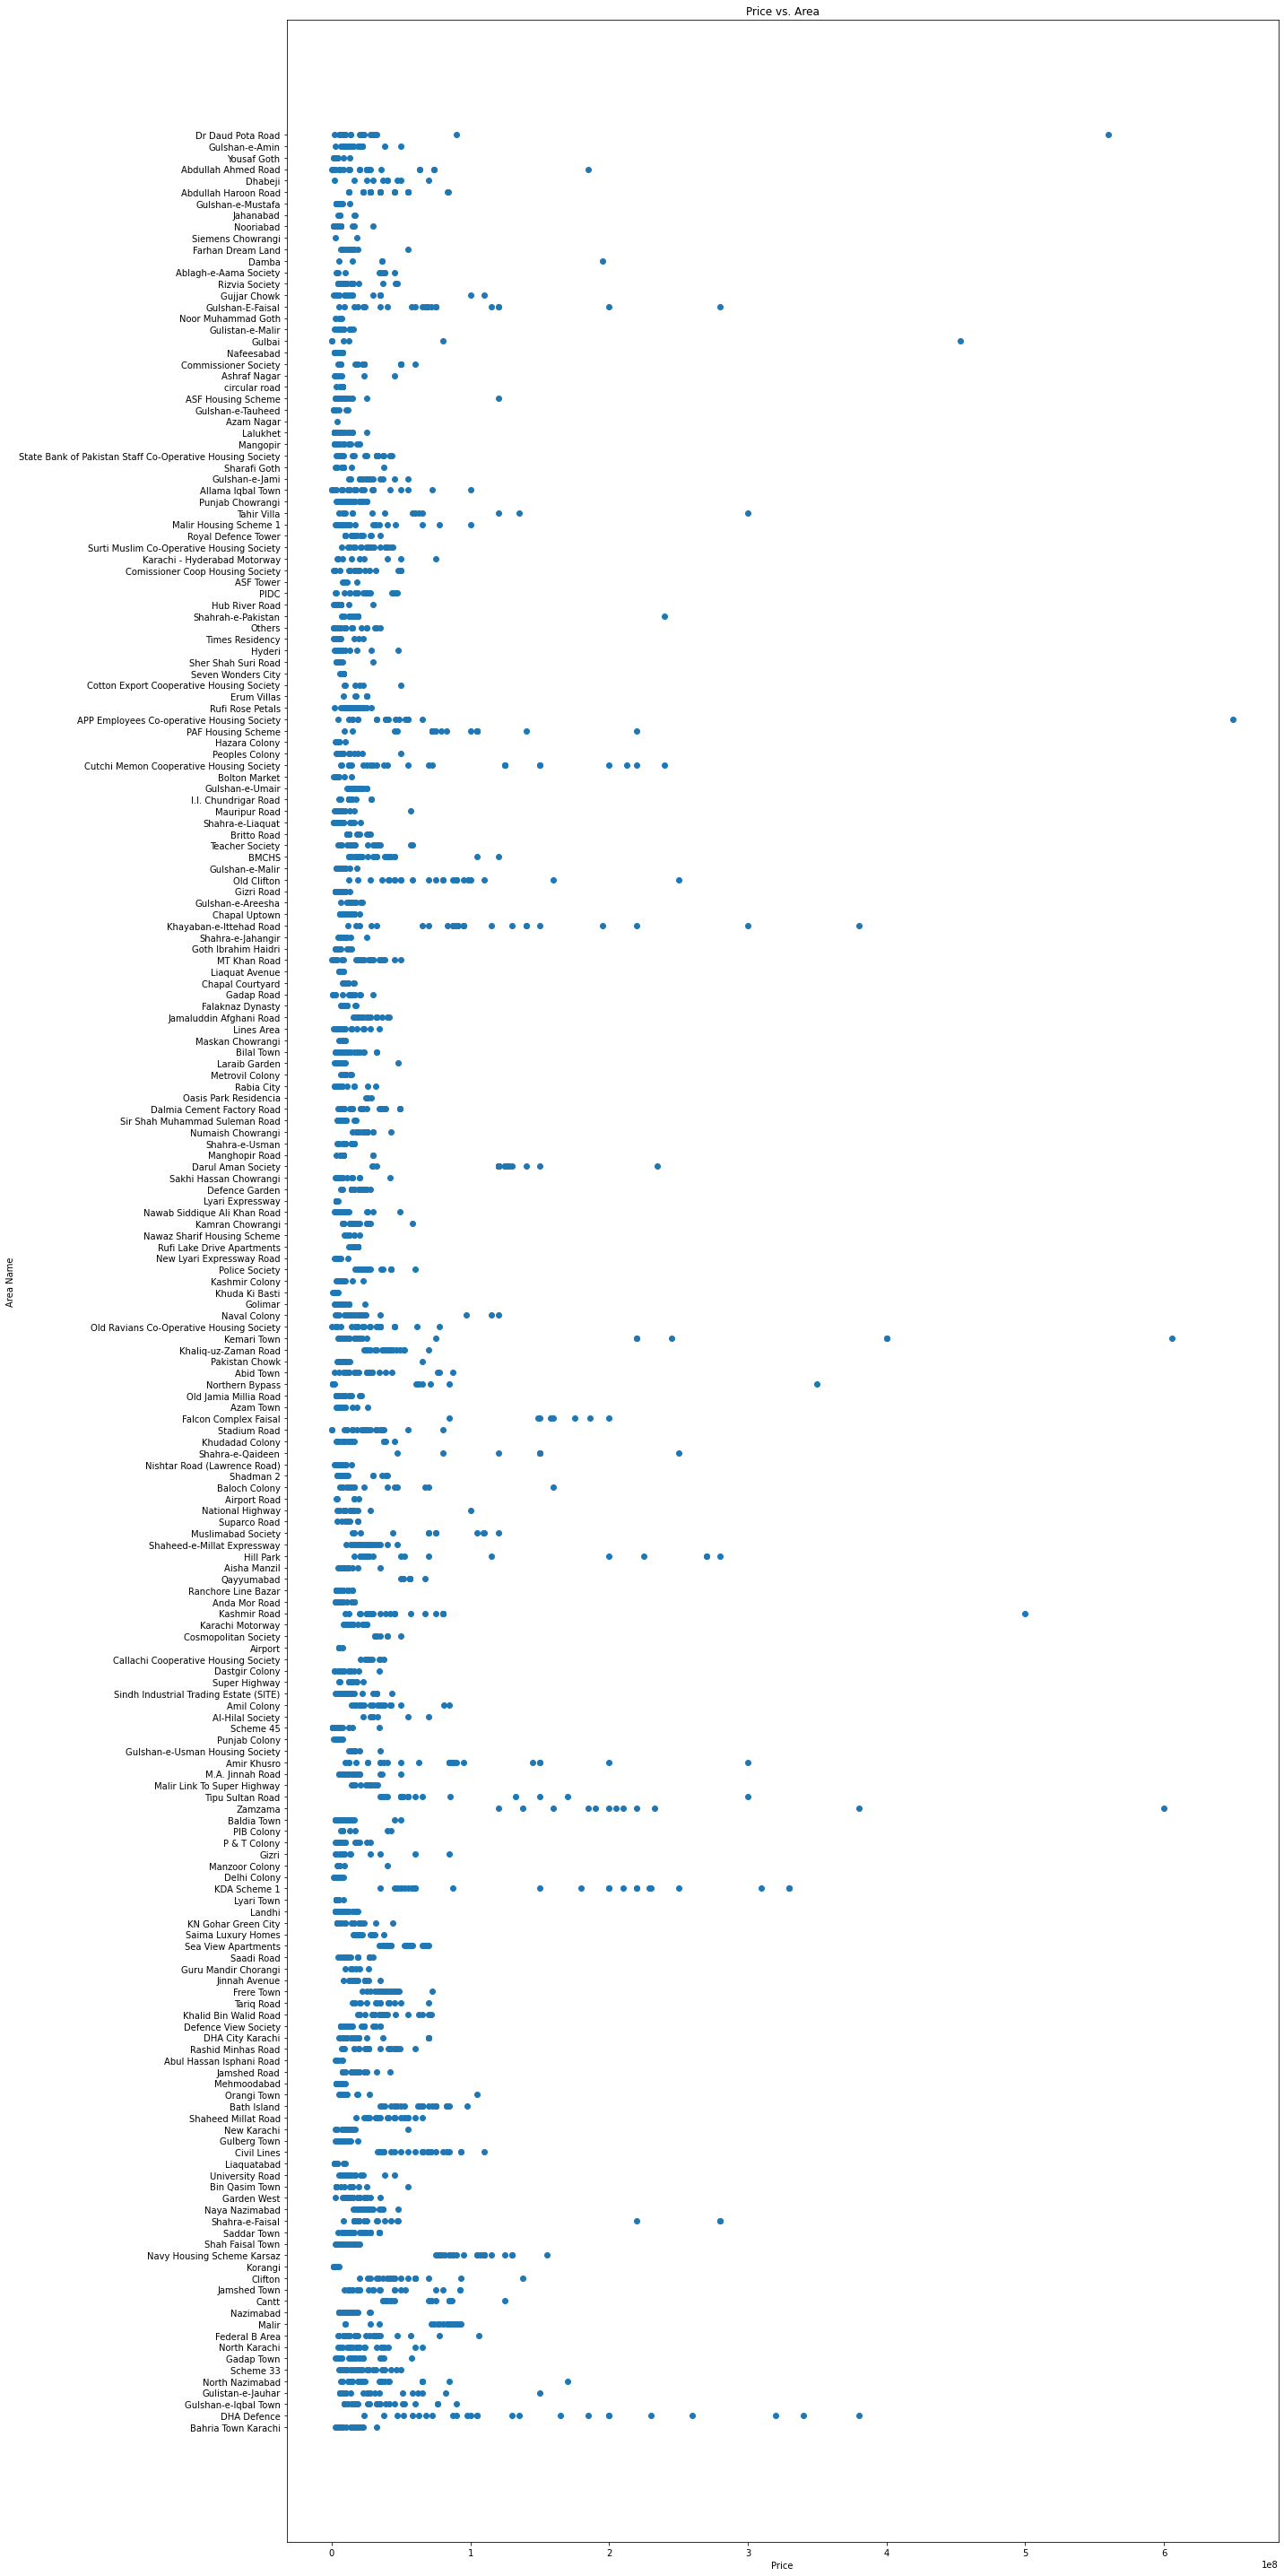

In [93]:
### Scatter Plot - Price vs. Area Name

plt.figure(figsize=(20, 40))  # Set the figure size as per your preference

plt.scatter(x='Price', y='Area Name', data=df)
plt.xlabel('Price')
plt.ylabel('Area Name')
plt.title('Price vs. Area')
# plt.xticks(rotation=90)

plt.tight_layout()  # Adjust the spacing of the plot

plt.show()

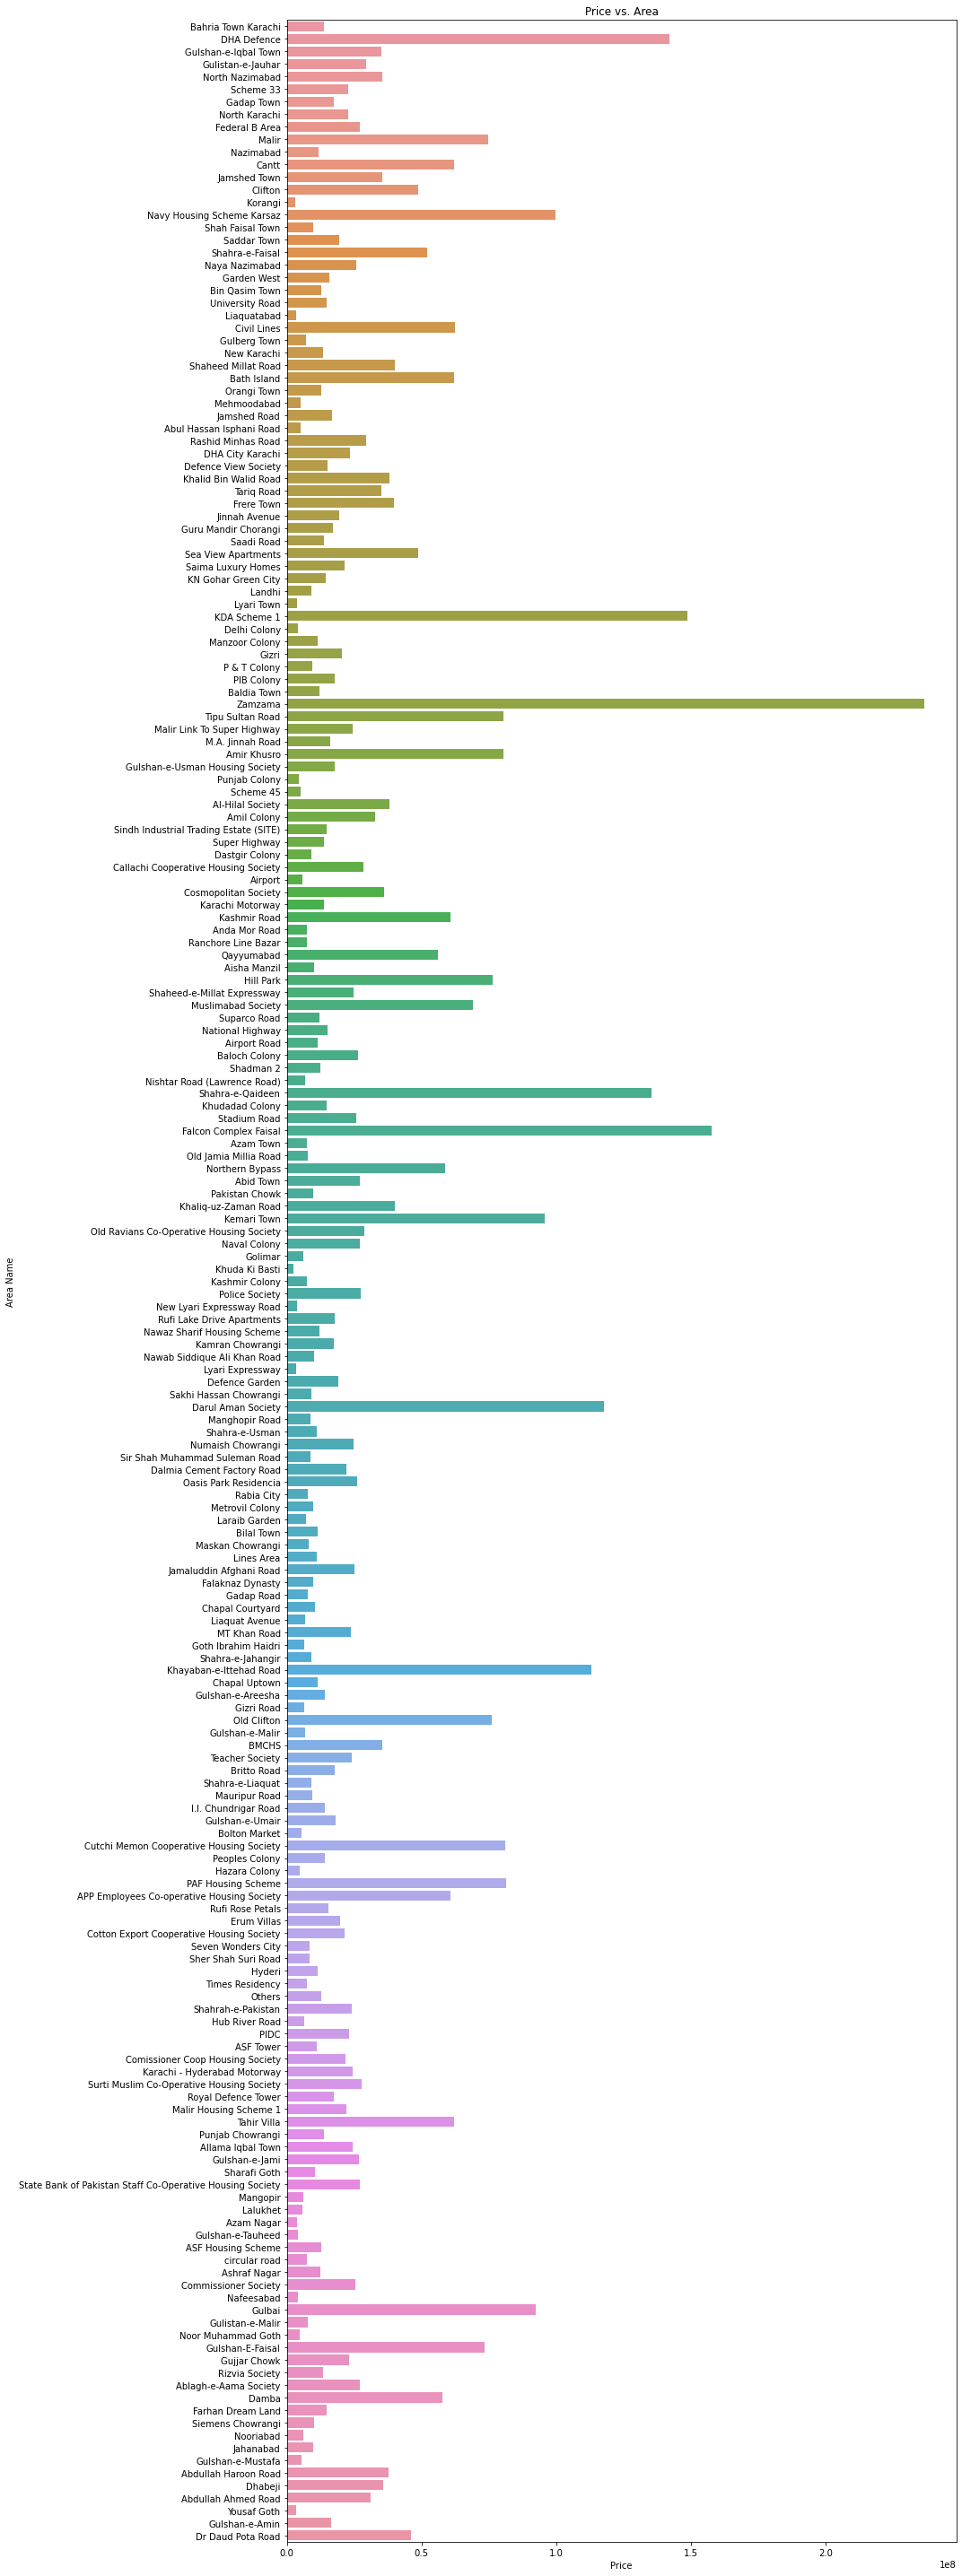

In [94]:
### Bar Plot - Price vs. Area Name

plt.figure(figsize=(15, 40))  # Set the figure size as per your preference

sns.barplot(x='Price', y='Area Name', data=df, ci=None)
plt.xlabel('Price')
plt.ylabel('Area Name')
plt.title('Price vs. Area')
# plt.xticks(rotation=90)

plt.tight_layout()  # Adjust the spacing of the plot

plt.show()

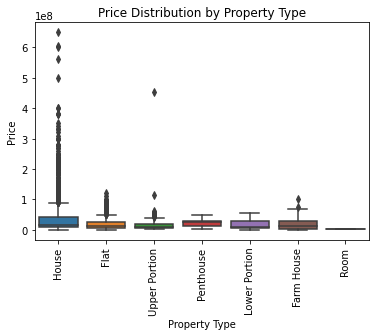

In [95]:
### Box Plot - Price Distribution by Property Type
    
sns.boxplot(x='Type', y='Price', data=df)
plt.xlabel('Property Type')
plt.ylabel('Price')
plt.title('Price Distribution by Property Type')
plt.xticks(rotation=90)
plt.show()

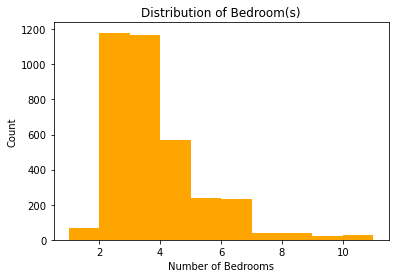

In [70]:
### Histogram - Distribution of Bedroom(s)

plt.hist(df['Bedroom(s)'], bins=10, color='orange')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Count')
plt.title('Distribution of Bedroom(s)')
plt.show()

In [ ]:
### WE CAN LATER MAKE A REGRESSION MODEL AS WELL LIKE PRICE PREDICTION etc...